# For AROUSAL

https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d

In [27]:
from os import listdir
from os.path import isfile, join
mypath = "/Users/apple/Desktop/eeglab14_1_2b/Granger Casuality/img/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [28]:
onlyfiles.sort()

In [29]:
from matplotlib import image
from matplotlib import pyplot
import numpy as np
from PIL import Image

In [30]:
X = []
for i in range(len(onlyfiles)):
    data = Image.open(mypath + onlyfiles[i])
    arr = np.array(data)
    #arr = arr[:,:,0:3]
    #result = np.zeros((32,32))
    #toadd = np.zeros((32,32,4))
    #for k in range(arr.shape[2]-1):
    #    result[:arr[:,:,k].shape[0],:arr[:,:,k].shape[1]] = arr[:,:,k] 
    #    toadd[:,:,k] = result
    X.append(arr)
print(len(X))
print(X[1].shape)

1280
(32, 32, 4)


In [31]:
import pandas as pd
df = pd.read_csv('/Users/apple/Desktop/eeglab14_1_2b/participant_ratings.csv',
                sep=r'\s*,\s*',engine = 'python', na_values = '?')
df.dropna()
Y_chart = pd.get_dummies(df, drop_first=True)
Y = Y_chart['Arousal'].tolist()
print(len(Y))

1280


In [32]:
for i in range(len(Y)):
    if Y[i] < 5:
        Y[i] = 0
    else:
        Y[i] = 1
print(len(Y))

1280


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=(40/len(Y)))

In [35]:
import numpy as np
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
print(X_train.shape)
print(y_train.shape)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print(X_test.shape)
print(y_test.shape)

(1240, 32, 32, 4)
(1240,)
(40, 32, 32, 4)
(40,)


In [36]:
print('Image dataset have shape =', X_train.shape)
print('Image dataset has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train.min(),
                        X_train.mean(), X_train.std(), X_train.max()))
print('')
print('Train label has shape =', y_train.shape)
print('Training label has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train.min(),
                        y_train.mean(), y_train.std(), y_train.max()))

Image dataset have shape = (1240, 32, 32, 4)
Image dataset has min/mean/std/max = 1.00/139.61/79.38/255.00

Train label has shape = (1240,)
Training label has min/mean/std/max = 0.00/0.59/0.49/1.00


In [37]:
def normalize_data(data): 
    data = data / data.max()
    return data

X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
print('Image dataset have shape =', X_train.shape)
print('Image dataset has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X_train.min(),
                        X_train.mean(), X_train.std(), X_train.max()))
print('')
print('Train label has shape =', y_train.shape)
print('Training label has min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train.min(),
                        y_train.mean(), y_train.std(), y_train.max()))

Image dataset have shape = (1240, 32, 32, 4)
Image dataset has min/mean/std/max = 0.00/0.55/0.31/1.00

Train label has shape = (1240,)
Training label has min/mean/std/max = 0.00/0.59/0.49/1.00


In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [39]:
transform = transforms.Compose(
 [transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.from_numpy(y_train)

In [40]:
trainset = utils.TensorDataset(tensor_x,tensor_y)

In [41]:
trainloader = utils.DataLoader(trainset,  batch_size= 40)

In [42]:
tensor_x_test = torch.stack([torch.Tensor(i) for i in X_test])
tensor_y_test = torch.from_numpy(y_test)

In [43]:
testset = utils.TensorDataset(tensor_x_test,tensor_y_test)
testloader = utils.DataLoader(testset,  batch_size=40)

In [44]:
device = torch.device("cpu")
classes = ('Positive', 'Negative')
print(device)

cpu


In [45]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [46]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images = images.permute(0, 3, 1, 2)
print(images.size())

torch.Size([40, 32, 32, 4])
torch.Size([40, 4, 32, 32])


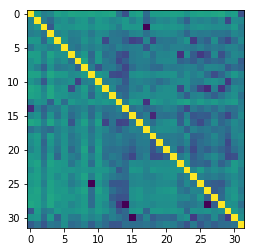

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
rows = 1
columns = 1
fig=plt.figure()
for i in range(1):
    fig.add_subplot(rows, columns, i+1)
    img = images[i]
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()

In [48]:
'''
kernal size 3*3
step size = 1
maximum pooled layer of 2*2
step size = 2
learning rate = 0.0001
batch size = 63
dropout rate = 0.5
k-fold: 5-fold cross validation
'''

'\nkernal size 3*3\nstep size = 1\nmaximum pooled layer of 2*2\nstep size = 2\nlearning rate = 0.0001\nbatch size = 63\ndropout rate = 0.5\nk-fold: 5-fold cross validation\n'

num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 10, 3, padding=1)
        self.drop_rate = 0.4
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(20*8*8, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(100, num_classes),
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 8 * 8)
        x = self.classifier(x)
        return x
    
net = Net()
net.to(device)

In [49]:
num_classes = 2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 3)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.drop_out = nn.BatchNorm2d(20)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(16*6*6, 96),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(96, 6),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(6, num_classes),
        )

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        #x = F.dropout2d(x, p=0.5)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.flat(x))
        x = self.classifier(x)
        return x
    
    def flat(self, x):
        size = x.size()[1:]
        num = 1
        for s in size:
            num *= s
        return num
    
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (drop_out): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=576, out_features=96, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=96, out_features=6, bias=True)
    (5): Dropout(p=0.5)
    (6): ReLU(inplace)
    (7): Linear(in_features=6, out_features=2, bias=True)
  )
)

In [ ]:
'''with torch.no_grad():
    net = NeuralNet(model, criterion= nn.CrossEntropyLoss,
                max_epochs = args.epochs,
                lr = args.learning_rate,
                batch_size = 32,
                optimizer=optim.SGD,
                optimizer_momentum = 0.09,
                iterator_train__shuffle = True,
                iterator_train__num_workers = 4,
                iterator_valid__shuffle = True,
                iterator_valid__num_workers = 4,
                train_split= predefined_split(valid_dataset),
                callbacks= [ lr_scheduler, epoch_acc, checkpoint],
                device = 'cuda')
params = {
        'lr':[0.01,0.02],
        'max_epochs':[10,20],
        'module_num_units': [10,20],
        }
gs = GridSearchCV(net, params,refit=False, cv=5, scoring='accuracy')
gs.fit(train_dataset, y=None)'''

"with torch.no_grad():\n    net = NeuralNet(model, criterion= nn.CrossEntropyLoss,\n                max_epochs = args.epochs,\n                lr = args.learning_rate,\n                batch_size = 32,\n                optimizer=optim.SGD,\n                optimizer_momentum = 0.09,\n                iterator_train__shuffle = True,\n                iterator_train__num_workers = 4,\n                iterator_valid__shuffle = True,\n                iterator_valid__num_workers = 4,\n                train_split= predefined_split(valid_dataset),\n                callbacks= [ lr_scheduler, epoch_acc, checkpoint],\n                device = 'cuda')\nparams = {\n        'lr':[0.01,0.02],\n        'max_epochs':[10,20],\n        'module_num_units': [10,20],\n        }\ngs = GridSearchCV(net, params,refit=False, cv=5, scoring='accuracy')\ngs.fit(train_dataset, y=None)"

In [ ]:
loss_func = nn.CrossEntropyLoss()
#opt = torch.optim.Adam(net.parameters(), lr= 0.001)
#opt = torch.optim.Adamax(net.parameters(), lr=0.005)
#opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
opt = torch.optim.Adagrad(net.parameters(), lr=0.005)
avg_losses = [] 
epochs = 1000 
print_freq = 20
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        if i % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
print('Finished Training.')

[epoch: 0, i:    19] avg mini-batch loss: 0.692
[epoch: 1, i:    19] avg mini-batch loss: 0.678
[epoch: 2, i:    19] avg mini-batch loss: 0.681
[epoch: 3, i:    19] avg mini-batch loss: 0.681
[epoch: 4, i:    19] avg mini-batch loss: 0.676
[epoch: 5, i:    19] avg mini-batch loss: 0.675
[epoch: 6, i:    19] avg mini-batch loss: 0.673
[epoch: 7, i:    19] avg mini-batch loss: 0.674
[epoch: 8, i:    19] avg mini-batch loss: 0.676
[epoch: 9, i:    19] avg mini-batch loss: 0.674
[epoch: 10, i:    19] avg mini-batch loss: 0.676
[epoch: 11, i:    19] avg mini-batch loss: 0.677
[epoch: 12, i:    19] avg mini-batch loss: 0.671
[epoch: 13, i:    19] avg mini-batch loss: 0.676
[epoch: 14, i:    19] avg mini-batch loss: 0.674
[epoch: 15, i:    19] avg mini-batch loss: 0.678
[epoch: 16, i:    19] avg mini-batch loss: 0.676
[epoch: 17, i:    19] avg mini-batch loss: 0.675
[epoch: 18, i:    19] avg mini-batch loss: 0.677
[epoch: 19, i:    19] avg mini-batch loss: 0.671
[epoch: 20, i:    19] avg mini

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 40 test images: %d %%' % (100 * correct / total))
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        one = torch.tensor(1, dtype=torch.float, device=device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(total)
print('Accuracy of the network on the 1240 training images: %d %%' % (100 * correct / total))
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        one = torch.tensor(1, dtype=torch.float, device=device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(40):
            label = labels[i]
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
'''
kernal size 3*3
step size = 1
maximum pooled layer of 2*2
step size = 2
learning rate = 0.0001
batch size = 63
dropout rate = 0.5
k-fold: 5-fold cross validation
'''